In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
print(cwd)

/home/lgraff/Documents/Multimodal_Accessibility


In [5]:
# read data
cwd = os.getcwd()
filepath = os.path.join(cwd, 'Data', 'Input_Data', 'Allegheny_sample_xd_part1', 'Allegheny_sample_xd_part1.csv')
df = pd.read_csv(filepath)
filepath = os.path.join(cwd, 'Data', 'Input_Data', 'Allegheny_sample_xd_part1', 'XD_Identification.csv')
df_xd = pd.read_csv(filepath)


In [6]:
df_xd.head()

,xd,road-name,road-num,bearing,miles,frc,county,state,zip,timezone_name,start_latitude,start_longitude,end_latitude,end_longitude
0,133749395,STOWE AVE,NaN,N,0.255702,5,ALLEGHENY,PA,15136,America/New_York,40.477290,-80.066790,40.480550,-80.069040
1,1310381477,PA-28 S,28.0,S,0.592731,2,ALLEGHENY,PA,15065,America/New_York,40.649637,-79.723247,40.641602,-79.720442
2,387978180,BEECHNUT DR,NaN,S,0.092597,5,ALLEGHENY,PA,15205,America/New_York,40.453990,-80.082340,40.453040,-80.083580
3,133749397,MONONGAHELA AVE,NaN,S,0.065070,5,ALLEGHENY,PA,15218,America/New_York,40.421920,-79.890390,40.421070,-79.889860
4,132943890,MULLBERRY WAY,NaN,W,0.076291,5,ALLEGHENY,PA,15222,America/New_York,40.448350,-79.989070,40.447630,-79.990170


In [7]:
# merge tt with id data
df_merge = df.merge(df_xd, how='inner', left_on='xd_id', right_on='xd')

In [8]:
df_merge.head()

,xd_id,measurement_tstamp,speed,average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,xd,road-name,...,miles,frc,county,state,zip,timezone_name,start_latitude,start_longitude,end_latitude,end_longitude
0,133749395,2022-09-01 00:00:00,22.0,22.0,22.0,41.84,10.0,NaN,133749395,STOWE AVE,...,0.255702,5,ALLEGHENY,PA,15136,America/New_York,40.47729,-80.06679,40.48055,-80.06904
1,133749395,2022-09-01 00:05:00,22.0,22.0,22.0,41.84,10.0,NaN,133749395,STOWE AVE,...,0.255702,5,ALLEGHENY,PA,15136,America/New_York,40.47729,-80.06679,40.48055,-80.06904
2,133749395,2022-09-01 00:10:00,22.0,22.0,22.0,41.84,10.0,NaN,133749395,STOWE AVE,...,0.255702,5,ALLEGHENY,PA,15136,America/New_York,40.47729,-80.06679,40.48055,-80.06904
3,133749395,2022-09-01 00:15:00,22.0,22.0,22.0,41.84,10.0,NaN,133749395,STOWE AVE,...,0.255702,5,ALLEGHENY,PA,15136,America/New_York,40.47729,-80.06679,40.48055,-80.06904
4,133749395,2022-09-01 00:20:00,22.0,22.0,22.0,41.84,10.0,NaN,133749395,STOWE AVE,...,0.255702,5,ALLEGHENY,PA,15136,America/New_York,40.47729,-80.06679,40.48055,-80.06904


In [9]:
def add_time_cols(df, datetime_col):
    df = df.copy()
    df['month'] = df[datetime_col].dt.month
    df['day'] = df[datetime_col].dt.day
    df['time'] = df[datetime_col].dt.time
    df['hour'] = df[datetime_col].dt.hour
    df['minute'] = df[datetime_col].dt.minute
    return df

In [31]:
# get variation across x hour period 
def intraday_variation(df, frc, hour_start, hour_end):
    df = df.copy()
    df = df[df['frc'] == frc]
    condition = (df.day == 1) & (df.hour.between(hour_start,hour_end-1))  # day = 1 for a single representative day
    df_time = df[condition]
    df_grouped = df_time.groupby('measurement_tstamp')[['hour','minute','travel_time_seconds']].mean().reset_index()  # for the given frc, take the mean travel time at a timestamp
    return df_grouped
    # # make plot
    # fig, ax = plt.subplots()
    # ax.plot(df_grouped.measurement_tstamp, df_grouped.travel_time_seconds)
    # ax.set_title('FRC =' + str(frc))
    # ax.set_xlabel('time')
    # ax.set_ylabel('travel time (s)')
    # ax.tick_params(axis='x', rotation=90)



In [48]:
tt_ratios = []
for frc in range(1,6):
    df_intraday_frc = intraday_variation(df_merge, 2, 7, 9)
    for hr in [7,8]:
        for min in range(0,60,5):
            # get the base case travel time associated with the 7am
            condition = (df_intraday_frc['hour'] == 7) & (df_intraday_frc['minute'] == 0)
            base_time = df_intraday_frc[condition]['travel_time_seconds'].values[0]
            condition = (df_intraday_frc['hour'] == hr) & (df_intraday_frc['minute'] == min)
            # get the travel time at that timestamp
            tt_timestamp = df_intraday_frc[condition]['travel_time_seconds'].values[0]
            # check the ratio between tt_timestamp and the base_time. if less than 1, adjust it to 1 since it makes sense to assume 7am is free flow
            tt_ratio = round(max(tt_timestamp/base_time, 1), 3)
            tt_ratios.append((frc, hr, min, tt_ratio))
# create a lookup table
df_tt_ratios = pd.DataFrame(tt_ratios, columns =['frc', 'hr', 'min', 'tt_ratio'])

In [41]:
plt.scatter(df_)

[(1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (1, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (2, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0),
 (3, 7, 0, 1.0

,frc,hr,min,tt_ratio
24,2,7,0,1.000
25,2,7,5,1.000
26,2,7,10,1.009
27,2,7,15,1.033
28,2,7,20,1.042
29,2,7,25,1.069
30,2,7,30,1.081
31,2,7,35,1.114
32,2,7,40,1.124
33,2,7,45,1.148


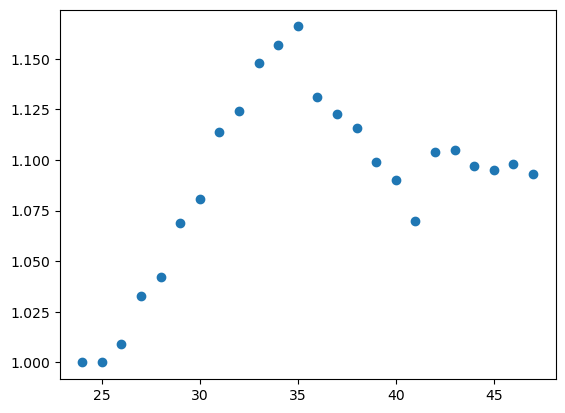

In [49]:
df_tt_ratios.head()
df_test = df_tt_ratios[df_tt_ratios['frc']==2]
plt.scatter(x=df_test.index, y=df_test['tt_ratio'])
df_test.head(30)

1


/tmp/ipykernel_4898/2672855626.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df_time.groupby('measurement_tstamp').mean().reset_index()  # for the given frc, take the mean travel time at a timestamp


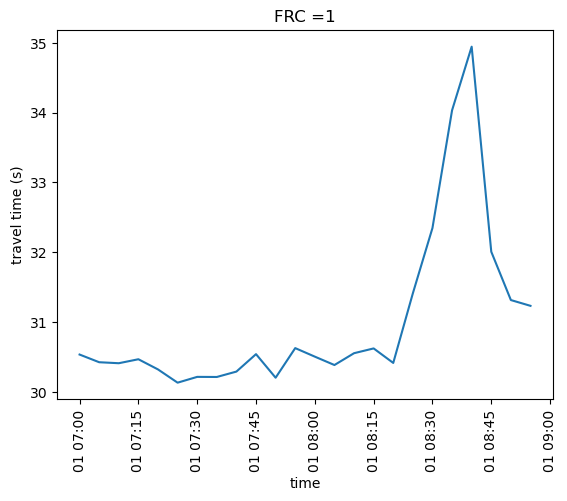

In [11]:
# add datetime columns
df_merge['measurement_tstamp'] = pd.to_datetime(df_merge['measurement_tstamp']) 
df_merge = add_time_cols(df_merge, 'measurement_tstamp')


# for frc in range(1,6): # df_merge['frc'].unique().tolist():
#     print(frc)
#     intraday_variation(df_merge, frc, 7, 9)

In [18]:
def day2day_variation(df, frc, hour, minute):
    df = df.copy()
    df = df[df['frc'] == frc] # subset by frc
    df = df[(df['hour']==hour) & (df['minute']==minute)]  # subset by hour and minute
    df_day = df.groupby('day')[['hour', 'minute', 'travel_time_seconds']].mean().sort_values(by='travel_time_seconds', ascending=True)
    #df_day.reset_index(inplace=True)
    #fig,ax = plt.subplots()
    #ax.scatter(x=df_day.index, y=df_day['travel_time_seconds'])
    minTT = df_day['travel_time_seconds'].min()
    maxTT = df_day['travel_time_seconds'].max()
    reliability_ratio = maxTT/minTT
    #print(reliability_ratio)
    return(reliability_ratio)

In [19]:
start_time = 7
end_time = 9
frc_hr_min = [(frc,hr,min) for frc in range(1,6) for hr in [start_time, end_time-1] for min in range(0,60,5)]
rel_ratio = [day2day_variation(df_merge, frc, hr, min) for frc in range(1,6) for hr in [start_time, end_time-1] for min in range(0,60,5)]

In [26]:
frc_hr_min = [(frc,hr,min) for frc in range(1,6) for hr in [start_time, end_time-1] for min in range(0,60,5)]
frc_hr_min_list = list(zip(*frc_hr_min))
frcs = frc_hr_min_list[0]
hrs = frc_hr_min_list[1]
mins = frc_hr_min_list[2]
# Calling DataFrame constructor after zipping
# lists, with columns specified
df_rel_ratio = pd.DataFrame(list(zip(frcs, hrs, mins, rel_ratio)), columns =['frc', 'hr', 'min', 'rel_ratio'])
df_rel_ratio.head()  # this df will serve as a lookup table. 

# TODO: save df_rel_ratio to Output_Data

,frc,hr,min,rel_ratio
0,1,7,0,1.139649
1,1,7,5,1.125810
2,1,7,10,1.121510
3,1,7,15,1.132032
4,1,7,20,1.147639


In [ ]:
# now find reliability i.e. 95th percentile travel time. use all 10 days
#day2day_variation(df_merge)

# test for 7:30
hour = 7
minute = 30
df_specific_time = df_merge[(df_merge['hour']==7) & (df_merge['minute']==30)]
df_specific_time.head()


In [ ]:
df_specific_time = df_specific_time[df_specific_time['frc'] == frc]
df_day = df_specific_time.groupby('day')[['measurement_tstamp','travel_time_seconds']].mean().sort_values(by='travel_time_seconds', ascending=True)
#df_day.reset_index(inplace=True)
fig,ax = plt.subplots()
ax.scatter(x=df_day.index, y=df_day['travel_time_seconds'])
minTT = df_day['travel_time_seconds'].min()
maxTT = df_day['travel_time_seconds'].max()
reliability_ratio = maxTT/minTT
print(reliability_ratio)


In [ ]:
condition = (df_test.day == 1) & (df_test.hour.between(7,9)) 
df_79 = df_test[condition]
df_79['smoothed_tt'] = df_79['travel_time_seconds'].rolling(5).mean()
fig, ax = plt.subplots()
ax.plot(df_79.measurement_tstamp, df_79.smoothed_tt)

In [ ]:
fig, ax = plt.subplots()
ax.plot(df_79.measurement_tstamp, df_79.travel_time_seconds)

In [ ]:
df_merge['measurement_tstamp'] = pd.to_datetime(df_merge['measurement_tstamp']) 
df = add_time_cols(df_merge, 'measurement_tstamp')

In [ ]:
# choose xd_id == 133749395
# choose a single time i.e. 08:00:00
# plot x = day, y = travel_time 